# 15. 어드밴티지 액터-크리틱 (A2C)

A2C는 **정책 경사(Policy Gradient)**와 **시간차 학습(TD Learning)**을 결합한 방법이다. REINFORCE의 단점인 높은 분산(Variance)과 느린 학습 속도를 개선하기 위해, **크리틱(Critic)**이라는 가치 신경망을 도입했다.

* **액터(Actor, ):** 행동을 선택하는 정책 신경망. (REINFORCE와 동일)
* **크리틱(Critic, ):** 상태의 가치를 평가하는 신경망. (반환값  대신 사용)

업데이트 식은 다음과 같다.

여기서  부분을 **어드밴티지(Advantage)**라고 부르며, 실제 보상이 예측된 가치보다 얼마나 더 좋은지를 나타낸다.

### 0. 라이브러리 설정

최신 버전인 `gymnasium`과 `torch`를 불러온다. 병렬 환경 처리를 위해 멀티프로세싱 관련 모듈도 사용한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 1. 환경 설정 및 전처리

이번 실습에서는 **Acrobot-v1** 환경을 사용한다. 2개의 링크로 연결된 로봇 팔을 흔들어 일정 높이 이상으로 올리는 문제다.

A2C는 여러 개의 환경을 동시에 실행하여 다양한 데이터를 수집하는 것이 성능에 중요하다. 여기서는 학습 속도를 위해 `gymnasium.vector.SyncVectorEnv` (또는 `AsyncVectorEnv`)를 사용하여 병렬 환경을 구성한다.

In [2]:
# 병렬 환경 생성 함수
def make_env(env_id, seed):
    def thunk():
        env = gym.make(env_id)
        # 시드 설정 (필요시)
        # env.reset(seed=seed)
        return env
    return thunk

# CPU 코어 수만큼 환경 생성
num_envs = os.cpu_count() or 1
env_id = "Acrobot-v1"

# Gymnasium의 벡터 환경 사용 (자동으로 병렬 처리)
# SyncVectorEnv: 순차적 실행 (디버깅 용이), AsyncVectorEnv: 병렬 실행 (속도 빠름)
envs = gym.vector.SyncVectorEnv([make_env(env_id, i) for i in range(num_envs)])

# 상태 차원 및 행동 개수 확인 (단일 환경 기준)
# 벡터 환경의 observation_space는 배치 차원이 추가되어 있음
single_observation_space = envs.single_observation_space
single_action_space = envs.single_action_space

print(f"Number of environments: {num_envs}")
print(f"State shape: {single_observation_space.shape}")
print(f"Num actions: {single_action_space.n}")

Number of environments: 40
State shape: (6,)
Num actions: 3


---

## 2. 신경망 정의 (Actor & Critic)

액터와 크리틱 네트워크를 정의한다. 두 네트워크는 입력을 공유하거나 별도로 만들 수 있는데, 여기서는 별도의 네트워크로 구현한다.

### 2.1 액터 (Actor) - 정책

상태를 받아 행동의 확률 분포(Softmax)를 출력한다.

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

actor = Actor(single_observation_space.shape[0], single_action_space.n).to(device)

### 2.2 크리틱 (Critic) - 가치 함수

상태를 받아 스칼라 값(가치)을 출력한다.

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

critic = Critic(single_observation_space.shape[0]).to(device)

---

## 3. A2C 알고리즘 구현

A2C는 **n-step TD** 방식을 주로 사용한다. 즉, n번 스텝을 진행한 후 얻은 보상들과 마지막 상태의 가치 추정치를 이용하여 업데이트한다.

업데이트 로직:

1. 환경에서  스텝 동안 데이터를 수집한다.
2. TD 타겟(Target)을 계산한다.
*  (부트스트랩)
*  (역순으로 계산)


3. 어드밴티지 계산:
4. 액터 손실:
5. 크리틱 손실:  (MSE)
6. 엔트로피 보너스: 탐험을 장려하기 위해 엔트로피를 최대화하는 항 추가 (선택)

In [5]:
def a2c(envs, actor, critic, episodes, n_steps=5, alpha=1e-4, gamma=0.99):
    # 옵티마이저 설정
    optimizer_actor = optim.AdamW(actor.parameters(), lr=1e-3)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=1e-3)

    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    # 초기 상태 (배치 크기: num_envs)
    states, _ = envs.reset()
    states = torch.from_numpy(states).float().to(device)

    # 에피소드 루프 대신 총 업데이트 횟수로 진행하기도 하지만, 여기선 에피소드 개념을 유지하며 진행
    # 단, 병렬 환경 특성상 정확한 '에피소드' 단위 제어가 어려우므로 스텝 단위로 루프를 돔

    # 총 타임스텝 계산 (예: 200 에피소드 분량)
    total_updates = episodes * 200 // n_steps

    for update in tqdm(range(total_updates)):
        # 데이터를 저장할 리스트
        log_probs = []
        values = []
        rewards_list = []
        entropy_term = 0
        masks = []

        # 1. n-step 동안 데이터 수집
        for _ in range(n_steps):
            # 행동 선택
            probs = actor(states)
            dist = torch.distributions.Categorical(probs)
            actions = dist.sample()

            # 가치 추정
            value = critic(states)

            # 환경 진행
            next_states, rewards, terminated, truncated, _ = envs.step(actions.cpu().numpy())

            # 종료 여부 마스크 (종료되었으면 0, 아니면 1)
            # terminated나 truncated 중 하나라도 True면 종료로 처리
            dones = np.logical_or(terminated, truncated)
            mask = torch.from_numpy(1 - dones.astype(int)).float().to(device).unsqueeze(1)

            # 저장
            log_probs.append(dist.log_prob(actions))
            values.append(value)
            rewards_list.append(torch.from_numpy(rewards).float().to(device).unsqueeze(1))
            masks.append(mask)
            entropy_term += dist.entropy().mean()

            # 상태 갱신
            states = torch.from_numpy(next_states).float().to(device)

        # 2. 마지막 상태의 가치 추정 (부트스트랩)
        # 마지막 스텝에서 끝났다면(mask=0) 가치는 0, 아니면 critic 예측값
        next_value = critic(states)
        returns = next_value

        actor_loss = 0
        critic_loss = 0

        # 3. 역순으로 어드밴티지 및 손실 계산
        for i in reversed(range(n_steps)):
            # TD Target 계산 (R_t = r_t + gamma * R_{t+1})
            # 마스크를 곱해서 종료된 에피소드의 미래 가치는 0으로 만듦
            returns = rewards_list[i] + gamma * returns * masks[i]

            # 어드밴티지: 타겟 - 가치 (detach를 통해 타겟은 고정)
            advantage = returns - values[i]

            # Actor Loss: -log_prob * advantage (detach)
            # advantage를 detach하지 않으면 critic까지 그라디언트가 흘러가므로 주의
            actor_loss += -(log_probs[i] * advantage.detach()).mean()

            # Critic Loss: MSE(return, value)
            critic_loss += F.mse_loss(returns, values[i])

        # 엔트로피 보너스 (선택 사항, 탐험 촉진)
        # actor_loss -= 0.001 * entropy_term

        # 4. 업데이트
        optimizer_actor.zero_grad()
        actor_loss.backward()
        optimizer_actor.step()

        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())

        # 시각화를 위한 평균 보상 추적 (정확하지 않음, 근사치)
        if update % 10 == 0:
             stats['Returns'].append(torch.stack(rewards_list).sum().item() / num_envs)

    return stats

---

## 4. 학습 실행

A2C 에이전트를 학습시킨다. Acrobot 환경은 로봇 팔을 반동을 이용해 위로 올려야 하는 꽤 어려운 제어 문제다. 병렬 환경을 사용하므로 학습이 비교적 빠르게 진행된다.

In [6]:
print("A2C 학습 시작...")
# 학습 스텝 수 조정 (예: 500 단위로 업데이트 반복)
stats = a2c(envs, actor, critic, episodes=1000)
print("학습 완료!")

A2C 학습 시작...


100%|██████████| 40000/40000 [35:16<00:00, 18.90it/s]

학습 완료!


### 4.1 학습 결과 시각화

손실(Loss)과 평균 보상(Returns)의 변화를 확인한다.

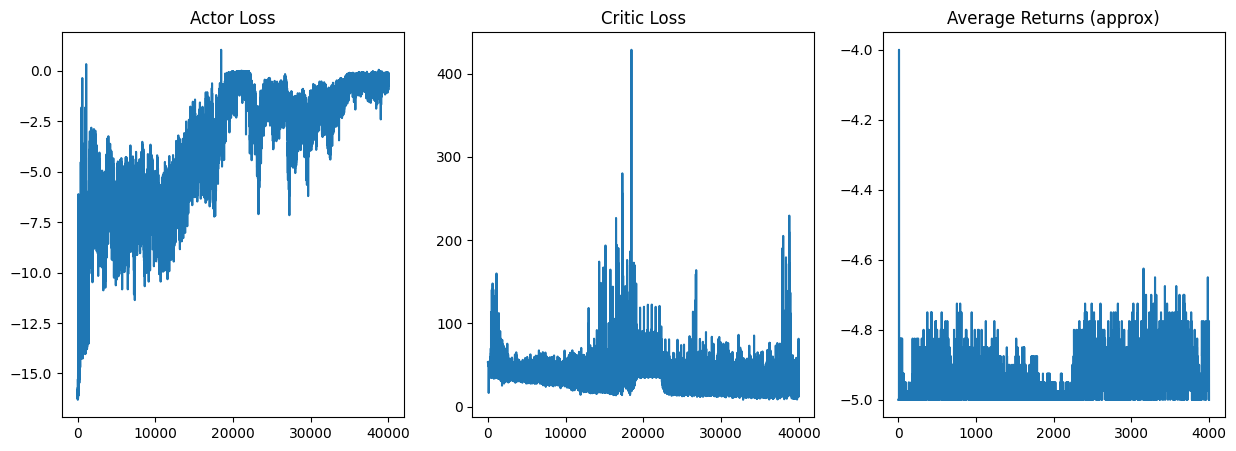

In [7]:
def plot_stats(stats):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].plot(stats['Actor Loss'])
    axs[0].set_title("Actor Loss")

    axs[1].plot(stats['Critic Loss'])
    axs[1].set_title("Critic Loss")

    axs[2].plot(stats['Returns'])
    axs[2].set_title("Average Returns (approx)")

    plt.show()

plot_stats(stats)

### 4.2 에이전트 테스트

학습된 모델을 단일 환경에서 테스트한다.

Episode 3: Steps=73, Reward=-72.0


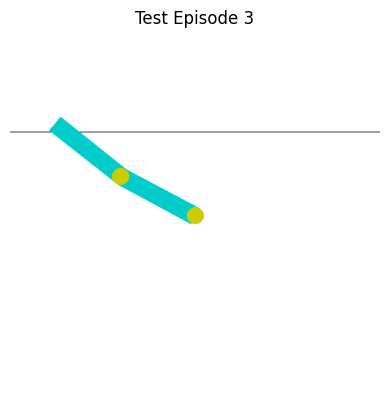

In [8]:
from IPython import display

def test_agent(env_id, actor, episodes=3):
    # 테스트용 단일 환경 생성
    env = gym.make(env_id, render_mode='rgb_array')

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        step = 0
        total_reward = 0

        img = plt.imshow(env.render())
        plt.axis('off')
        plt.title(f"Test Episode {ep+1}")

        while not done:
            # 상태 텐서 변환
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

            # 행동 선택 (확률적 or Greedy)
            with torch.no_grad():
                probs = actor(state_tensor)
                action = torch.argmax(probs).item() # Greedy

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            step += 1

        print(f"Episode {ep+1}: Steps={step}, Reward={total_reward}")

    env.close()

test_agent("Acrobot-v1", actor, episodes=3)

### 요약

A2C는 정책 경사와 가치 기반 학습의 장점을 결합하여 안정적이고 빠른 학습을 가능하게 한다. 특히 **병렬 환경**을 통해 데이터 수집 효율을 극대화하는 것이 특징이며, 이후 PPO(Proximal Policy Optimization)와 같은 최신 알고리즘의 기반이 되었다.